In [11]:
# Import necessary packages

import pandas as pd
import numpy as np
import string

from collections import defaultdict
import json
import unicodedata
import mistune
from bs4 import BeautifulSoup # xml data parsing
import re # Regular expressions

import xmltodict 
import gc # garbage collection
# xmltodict is a library that aims at making XML feel like working with JSON.

### Wikivoyage provides datadumps to use them in buidling travel guides or any creative applications! Go Crazy!
The latest one can be found at: https://dumps.wikimedia.org/enwikivoyage/latest/

I have downloaded the *enwikivoyage-latest-pages-articles.xml* file and put it inside the data folder

The content should be converted to json for easier handling

#### Conversion table between json and python

Read: https://realpython.com/python-json/

In [9]:
def convert_xml_to_json(fname):
    '''
    Convert xml data to json
    '''
    
    with open(fname,'r',encoding='utf-8') as f:
        xml_str = f.read()      
    
    data = xmltodict.parse(xml_str)
    
    json_str = json.dumps(data)   # converts xmltodict output to json
    json_d = json.loads(json_str) # Converts the data to python object
    
    with open('../data/processed/wikidata.json','w') as jdata: # write the structured data into a file with json encoding
        json.dump(json_d,jdata, indent=2)
    return json_d

# Create the json file wikidata.json and store python equivalent of the data into jdata
_ = convert_xml_to_json('../data/raw/enwikivoyage-latest-pages-articles.xml') 

In [14]:
# load the json file. data_all is python dict decoded from json by json.load
with open('../data/processed/wikidata.json','r') as f:
    data_all = json.load(f)

## Data Exploration

In [15]:
# data_all is a dictionary. So, let us first look into the keys
print(data_all.keys())

dict_keys(['mediawiki'])


In [16]:
# Apparently it only has one key. Let us dig in deeper!
print(data_all['mediawiki'].keys())

dict_keys(['@xmlns', '@xmlns:xsi', '@xsi:schemaLocation', '@version', '@xml:lang', 'siteinfo', 'page'])


In [17]:
# load of garbage! We should find out more about all these fields. As of now, 'page' key looks reasonable. 
# First find out what type of data the 'page' keyword contain
print(type(data_all['mediawiki']['page']))

<class 'list'>


In [18]:
# So its a list. Let us check the first entry
print('Number of pages = {}'.format(len(data_all['mediawiki']['page'])))
print('The first element is: {}'.format(data_all['mediawiki']['page'][0]))

Number of pages = 62530
The first element is: {'title': '1770', 'ns': '0', 'id': '1', 'redirect': {'@title': 'Town of 1770'}, 'revision': {'id': '1', 'timestamp': '2009-03-02T02:54:37Z', 'contributor': {'username': 'Inas', 'id': '1816'}, 'comment': 'otherwise a number just looks weird.. (Import from wikitravel.org/en)', 'model': 'wikitext', 'format': 'text/x-wiki', 'text': {'@xml:space': 'preserve', '#text': '#REDIRECT [[Town of 1770]]'}, 'sha1': 'jjresq501njc7hkah05ux8kk4t1y605'}}


In [21]:
# So the contents of 'page' is stored in a list. Each element of which is a dict! 
# The first element looks some random thing.
data_all['mediawiki']['page'][106]

{'title': 'Acailandia',
 'ns': '0',
 'id': '145',
 'redirect': {'@title': 'Açailândia'},
 'revision': {'id': '4488',
  'timestamp': '2010-02-17T17:45:38Z',
  'contributor': {'username': '(WT-en) Burmesedays', 'id': '2571'},
  'comment': 'another squiggly driven redirect (Import from wikitravel.org/en)',
  'model': 'wikitext',
  'format': 'text/x-wiki',
  'text': {'@xml:space': 'preserve', '#text': '#REDIRECT [[Açailândia]]'},
  'sha1': '1wcaxriuysbnssv3re5p4k88zd8kodj'}}

### The keys of each page need to be investigated!

* title -- name of the point of interest
* timestamp -- time of last edit (maybe?)
* contributor -- the author of the page
* text -- contains the description. Also a dictionary. The '#text' field contains the actual description!

*The 'title' and 'text' fields are of actual use!*

In [22]:
# First store the list of pages into articles
articles = data_all['mediawiki']['page']

#### Let's write some function to clean up the content!

* The unicodedata module: contains Unicode character properties, such as character categories, decomposition data, and numerical values.
* Learn about unicodes, bytes, and strings in python here: https://www.youtube.com/watch?v=-cmlmaVSONg&t=5s
* Unicodedata documentation: https://docs.python.org/2.4/lib/module-unicodedata.html
* Handing files with contents in a differnet language: https://www.youtube.com/watch?v=nQkaBiOwsIo
* Unicode library explained: https://www.geeksforgeeks.org/unicodedata-unicode-database-python/

In [23]:
def rmdiacritics(char):
    '''
    Return the base character of char, by "removing" any
    diacritics like accents or curls and strokes and the like.
    '''
    try:
        desc = unicodedata.name(char)
        cutoff = desc.find(' WITH ')
        if cutoff != -1:
            desc = desc[:cutoff]
        result = unicodedata.lookup(desc)
    except ValueError:
        result = char
    except KeyError:
        result = char
    return result


def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    #print(nkfd_form)
    value = u"".join([rmdiacritics(c) for c in nkfd_form])
    value = unicodedata.normalize('NFKD', value).encode('ascii','ignore')
    return value.decode('utf-8')

# Create dictionary of titles that have concatenated names as the values. For example: San Francisco: San_Francisco
def clean_word(title):
    
    value = remove_accents(title)

    value = value.replace(' ','_')
    #value = value.encode()
    return value

In [24]:
# Demonstration of cleaning. satisfied?
clean_word('à a')

'a_a'

In [25]:
# Now, let us create another dictonary where keys are the travel destinations 
# Values are the associated description
articles_dict = {}
for article in articles:
    # Lets strip the accents
    title = article['title']
    title = clean_word(title)
    articles_dict[title] = article

In [26]:
# Check whether a destination is in the database
POI = 'Kota_Kinabalu'
print (POI in articles_dict.keys())

True


There are a lot of destinations in the articles_dict with little to no description. Additionally, repetitive articles, commonly with titles such as Wikivoyage and Category, offer to real value. Let us delete them entries! Note that:

* A Python dictionary throws a *KeyError* if you try to get an item with a key that is not currently in the dictionary. 
* The *defaultdict* function in contrast simply creates any items that you try to access (provided of course they do not exist yet). 

In [27]:
junk_articles_dict = defaultdict(int) # Initialize with a default dict
for article in articles:
    title = article['title']
    if ':' in title:
        junk_articles_dict[title.split(':')[0]] += 1 # Count number of entries with repetitive titles

print (len(junk_articles_dict))
junk_articles_dict

15


defaultdict(int,
            {'Wikivoyage': 1837,
             'Itinerary': 1,
             'La Manzanilla': 1,
             'Poland': 1,
             'MediaWiki': 164,
             'Template': 1542,
             'Help': 9,
             'Category': 4676,
             'File': 1352,
             'Module': 100,
             'General/Wikivoyage': 1,
             'Wts': 3,
             'WP': 1,
             'Sites of Japan’s Meiji Industrial Revolution': 1,
             'Draft': 1})

In [28]:
# Create a dictionary with articles without ':' in their titles
print ('Originally there were {} articles!'.format(len(articles)))

articles_dict = {}
for article in articles:
    # Lets strip the accents using unicodedata
        # Lets strip the accents
    title = article['title']
    title = clean_word(title)
    
    if ':' not in title:
        articles_dict[title] = article

print ('Now we have {} articles!'.format(len(articles_dict)))

Originally there were 62530 articles!
Now we have 51253 articles!


In [29]:
# Let's find out the length of the associated description for each of these articles
# Note that descriptions are stored in '#text' key

article_lengths_dict = {}
for key, value in articles_dict.items():
    try:
        article_length = len(value['revision']['text']['#text'])
    except:
        article_length = -1
    article_lengths_dict[key] = article_length

In [31]:
# Find out description length of a destination
POI = 'Chittoor'
if POI in article_lengths_dict.keys():
    print('The description of {} contains {} characters!'.format(POI,article_lengths_dict[POI]))
else:
    print('Sorry, {} is not in the database!'.format(POI))

The description of Chittoor contains 8595 characters!


In [32]:
# Lets create a histogram to see the distribution of # of characters
# First create a DataFrame for easier data handling

df_article_lengths = pd.DataFrame(list(article_lengths_dict.items()),columns=['title','length'])

In [33]:
# Check the distribution of entries with size < 10k

condition1 = df_article_lengths['length'] < 10000
df_article_lengths[condition1].hist(bins=20);

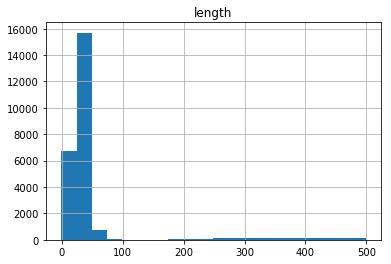

In [34]:
# Same plot for entries with less than 500 characters

condition2 = df_article_lengths['length'] < 500
df_article_lengths[condition2].hist(bins=20);

In [35]:
# Delete the articles with little to no description
cutoff = 100
condition3 = df_article_lengths['length'] > cutoff
df_article_char_plus = df_article_lengths[condition3]

In [36]:
final_titles = df_article_char_plus['title']

In [47]:
# Lets delete the articles with '(disambiguation)' in their title and make the final dataset

final_articles = {}
for title in final_titles:
    if '(disambiguation)' not in title:
        final_articles[title] = articles_dict[title]['revision']['text']['#text']
print('After the clean up job, we have {} articles!'.format(len(final_articles)))

After the clean up job, we have 27497 articles!


In [38]:
# Let's look into description of a particular place
POI = 'Chittoor'
if POI in final_articles.keys():
    nSize = min(1000,article_lengths_dict[POI])
    print('The description of {}: \n {} \n ...\n ...'.format(POI,final_articles[POI][0:nSize]))
else:
    print('Sorry, {} is not in the database!'.format(POI))

The description of Chittoor: 
 {{pagebanner|Mena-asia_default_banner.jpg}}
'''Chittoor''' is a city in [[Andhra Pradesh]], [[India]]. It is the headquarters of [[Chittoor_(district) | Chittoor district]]

Chittoor, very close to the revered temple of lord Balaji or Venkateswara at Tirupati, is also close to two eminent wildlife sanctuaries and the famous [[Horsley Hills]], a famous hill resort named after W.D Horsley.

Situated in the valley of the '''Ponni river''', Chittoor is a market for grain, sugarcane, and peanuts. Its industries include oilseed and rice milling. '''Jaggery''' from [[Aragonda]] area, a small town near Chittor is famous throughout the country.  Chittor is a major place for producing hatcheries and mangoes. The city is surrounded by mango and tamarind groves, and cattle are bred in the area. A district administrative centre, Chittoor was a British military post until 1884.

==Get in==
===By bus===
From Chennai : Take Route No:144 bus from Chennai Koyembedu Bus Sta

In [44]:
# Detele variables which are not needed anymore
del junk_articles_dict
del data_all
gc.collect()

12719

#### As apparent, the descriptions also need some cleaning up. We need to regular expression (re) library. Learn here:
* Re tutorial: https://www.youtube.com/watch?v=K8L6KVGG-7o

In [39]:
def clean_paragraph(string):
    # get rid of https:
    m = re.sub(r'(https?://\S+\ +\S+)', '', string)
    # get rid of [File:stuff]
    m = re.sub(r'\[File:[^)]*\]','', m)
    # get rid of \n
    m = re.sub(r'(\n)','', m)
    
    # get rid of ==stuff==
    m = re.sub(r'(\=+[^)]+\=+)','', m)
    #remove accents
    m = remove_accents(m)
    #get rid of ], [, '. E.g. [[Paris]] --> Paris
    m = re.sub(r'[\[\]\']','',m).strip()

    return m

def clean_sentence(string):
    # punctuation and numbers to be removed
    punctuation1 = re.compile(r'[*.?!,"0-9]')
    punctuation2 = re.compile(r'[-:;()|]')
    sent = re.sub(punctuation1,'', string)
    sent = re.sub(punctuation2, ' ', sent)
    return sent

In [40]:
# Try out here
string = 'seoul-incheon [[internatio]]*nal)'
nS = clean_paragraph(string)
print('After paragraph cleaning: \n {}'.format(nS))
nS = clean_sentence(nS)
print('After sentence cleaning: \n {}'.format(nS))

After paragraph cleaning: 
 seoul-incheon internatio*nal)
After sentence cleaning: 
 seoul incheon international 


In [41]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rajabiswas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
# create word tokens
import lxml
def convert_article_into_list_of_words(article):
    
    md = mistune.markdown(article,'utf-8')

    parsed_md = BeautifulSoup(md, 'html.parser')

    parsed_test_wo_dict = []
    
    #Grab all the paragraphs and lists
    for line in parsed_md.find_all(['p','li']):
        text = line.text

        
        #remove dictionaries by filtering on {{
        if '{{' not in text:
            #clean the paragraph by removing things like https:stuff, File:stuff
            text = clean_paragraph(text)
            #tokenize paragraph to sentences
            sentences = sent_tokenize(text)
            
            for sentence in sentences:
                #clean sentence by removing numbers and punctuations
                sent = clean_sentence(sentence).lower()
                #convert sentence to list of words
                word_list = sent.split()
                #keep the sentence if there are more than 3 words.
                if len(word_list) > 3:
                    parsed_test_wo_dict.append(word_list)
    return parsed_test_wo_dict

In [43]:
final_articles_words = {}

for key, value in final_articles.items():
    try:
        final_articles_words[key] = convert_article_into_list_of_words(str(value))
    except:
        final_articles_words[key] = 'tbc'

815

In [48]:
# Lets look into the cleaned up description
POI = 'Chittoor'
if POI in final_articles.keys():
    nSize = min(2,len(final_articles_words[POI]))
    print('The cleaned up description of {} looks like: \n {} \n ...\n ...'.format(POI,final_articles_words[POI][0:nSize]))
else:
    print('Sorry, {} is not in the database!'.format(POI))

The cleaned up description of Chittoor looks like: 
 [['chittoor', 'very', 'close', 'to', 'the', 'revered', 'temple', 'of', 'lord', 'balaji', 'or', 'venkateswara', 'at', 'tirupati', 'is', 'also', 'close', 'to', 'two', 'eminent', 'wildlife', 'sanctuaries', 'and', 'the', 'famous', 'horsley', 'hills', 'a', 'famous', 'hill', 'resort', 'named', 'after', 'wd', 'horsley'], ['situated', 'in', 'the', 'valley', 'of', 'the', 'ponni', 'river', 'chittoor', 'is', 'a', 'market', 'for', 'grain', 'sugarcane', 'and', 'peanuts']] 
 ...
 ...


In [50]:
del final_articles
gc.collect()

76

## Comments:
* Looks like a lot of things got deleted, which could be useful. 
* Task: Find a better way to clean up the descriptions.
* Could be useful to categorize the descriptions into 'Get in', 'See', 'Do' etc

In [51]:
# Gather only the words by removing []
final_DB = {}

for key, value in final_articles_words.items():
    key = key.lower()
    words = []
    
    for sentence in value:
        for word in sentence:
            words.append(word.lower())
    final_DB[key] = words

In [53]:
# Lets look into the final databade
POI = 'Chittoor'
POI = POI.lower()
if POI in final_DB.keys():
    nSize = min(50,len(final_DB[POI]))
    print('The words in the description of {} are: \n {} \n ...\n ...'.format(POI,final_DB[POI][0:nSize]))
else:
    print('Sorry, {} is not in the database!'.format(POI))

The words in the description of chittoor are: 
 ['chittoor', 'very', 'close', 'to', 'the', 'revered', 'temple', 'of', 'lord', 'balaji', 'or', 'venkateswara', 'at', 'tirupati', 'is', 'also', 'close', 'to', 'two', 'eminent', 'wildlife', 'sanctuaries', 'and', 'the', 'famous', 'horsley', 'hills', 'a', 'famous', 'hill', 'resort', 'named', 'after', 'wd', 'horsley', 'situated', 'in', 'the', 'valley', 'of', 'the', 'ponni', 'river', 'chittoor', 'is', 'a', 'market', 'for', 'grain', 'sugarcane'] 
 ...
 ...


In [55]:
# Store the final database in json format
with open('../data/processed/Final_DB.json','w') as j: # write the structured data into a file with json encoding
    json.dump(final_DB,j, indent=2)

In [56]:
del final_articles_words
gc.collect()

176

## Questions:
* How to select the POIs in south east asia?
* Seems like some useful descriptions get erased during clean-up. Need to investigate. 

# Content based filtering

In [58]:
# Read the final database in json format
with open('../data/processed/Final_DB.json','r') as j: # write the structured data into a file with json encoding
    final_db = json.load(j)

In [65]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS # need to install
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [62]:
## Load clean descripsions into pandas dataframe
DF_db = final_db.copy()
My_db = pd.DataFrame(list(DF_db.items()),columns=['Name','Description'])

My_db['Description'] = My_db['Description'].apply(' '.join)

In [63]:
# Let us now create the description corpus
df_desc = ' '.join(My_db['Description'])

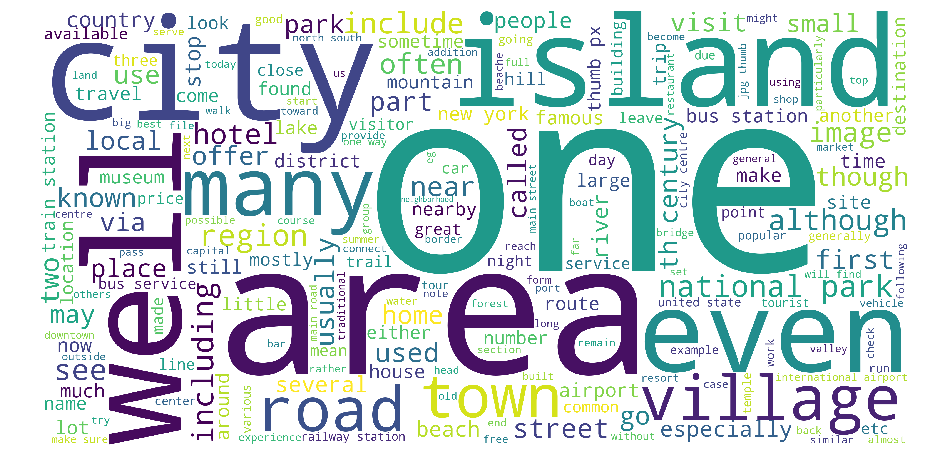

In [66]:
# Most frequent words in the database
df_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(df_desc)
plt.figure(figsize = (16,8))
plt.imshow(df_wordcloud)
plt.axis('off')
plt.show()

In [67]:
# TF-iDF
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english',max_features = 10000)
tfidf_matrix = tf.fit_transform(My_db['Description'])

In [68]:
# Find similarities between the places
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [69]:
# (optional)
# Iterate through each item's similar items and store the 100 most-similar!
# Results stores top 10 similar items accompanied with their similarity score
results = {}

for idx, row in My_db.iterrows():
    sim_idx = cosine_similarities[idx].argsort()[:-10:-1]
    sim_poi = [(My_db['Name'][i],cosine_similarities[idx][i]) for i in sim_idx]
    results[row['Name']] = sim_poi[1:]

In [70]:
# Find index of a place in My_db
def find_index(poi,db):
    for idx, row in db.iterrows():
        if(poi == row[0]):
            return idx
            break
    return -1

## Let's make predictions

In [72]:
# Asks users to enter 5 places they have visted to make predictions
count = 0
poi_names = []
poi_index = []


NP = input('How many places have you visited:')
NP = int(NP)

POI = input('Enter a POI:')
POI = POI.lower()
  
while count< int(NP):
    
    if POI in final_DB.keys():
        count = count + 1
        poi_names.append(POI)
        poi_index.append(find_index(POI,My_db))
        if count<int(NP):
            POI = input('Success! Enter another POI, {} more to go:'.format(NP-count))
            POI = POI.lower()
    else:
        POI = input('Fail! Try another one: {} more to go:'.format(NP-count))
        POI = POI.lower()
    
print('\n You have entered: \n')
print(poi_names)
print('\n The id of these places: \n')
print(poi_index)



## Recommend


# Build use profile by taking average
for i, idx in enumerate(poi_index):
    if i == 0:
        usr_prof = tfidf_matrix[idx,:]
    else:
        usr_prof = usr_prof + tfidf_matrix[idx,:]
usr_prof = usr_prof/5.0

# Compute similarity scores for the user profile
SIM =np.squeeze(linear_kernel(usr_prof,tfidf_matrix)) 
ind_sim = SIM.argsort()
ind_sim = ind_sim[::-1]
# Recommend
N = 20 # top N places
count = 0
i = 0
print('Top Recommendations: \n')

while (count <N):
    idx = ind_sim[i]
    if idx in poi_index: # already given by user
        i = i+1
    else:
        print('\n {} with score of = {}'.format(My_db.loc[idx]['Name'].upper(),round(SIM[idx],2)))
        count = count + 1
        i = i + 1

How many places have you visited: 6
Enter a POI: Brugge
Fail! Try another one: 6 more to go: Ghent
Success! Enter another POI, 5 more to go: Palamner
Fail! Try another one: 5 more to go: Brussels
Success! Enter another POI, 4 more to go: Capri
Success! Enter another POI, 3 more to go: Java
Success! Enter another POI, 2 more to go: Panama
Fail! Try another one: 2 more to go: Patagonia
Success! Enter another POI, 1 more to go: Amristar
Fail! Try another one: 1 more to go: Amritsar



 You have entered: 

['ghent', 'brussels', 'capri', 'java', 'patagonia', 'amritsar']

 The id of these places: 

[6686, 2544, 3037, 8560, 21643, 514]
Top Recommendations: 


 BELGIUM with score of = 0.28

 LEUVEN with score of = 0.25

 KORTRIJK with score of = 0.24

 BRUGES with score of = 0.23

 KRAAINEM with score of = 0.23

 INDONESIA with score of = 0.22

 FLANDERS with score of = 0.22

 WESTERN_JAVA with score of = 0.21

 CENTRAL_JAVA with score of = 0.2

 EAST_JAVA with score of = 0.2

 SEMARANG with score of = 0.2

 MECHELEN with score of = 0.2

 NETHERLANDS with score of = 0.19

 CHILE with score of = 0.19

 SEVILLE with score of = 0.19

 BLITAR with score of = 0.19

 NORTH_COAST_(WEST_JAVA) with score of = 0.18

 NICE with score of = 0.18

 OUDENAARDE with score of = 0.18

 JAKARTA with score of = 0.18
